In [ ]:
import numpy as np
import pandas as pd
import json
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Read Categories Json and Trending Data for US

In [ ]:
# Converts the JSON file into a pandas DataFrame
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
# Extracts the nested JSON under the items key to keep only the columns ['id', 'snippet.title']. Hence, creates a simpler DataFrame with just two columns: id and snippet.title.
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
# Renaming the column
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

# Load the CSV file into a DataFrame
data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')

# Convert 'publishedAt' to datetime format
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format = 'ISO8601', utc=True)

# Convert 'trending_date' to datetime format
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format = 'ISO8601', utc=True)


# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()

# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})

data_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,published_day_of_week,id,categoryName
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,Tuesday,22,People & Blogs
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",Tuesday,20,Gaming
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,Tuesday,24,Entertainment
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,Tuesday,10,Music
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,Tuesday,26,Howto & Style


In [ ]:
# Find cases where trending_date is before publishedAt
invalid_dates = data_df[data_df['trending_date'] < data_df['publishedAt']]

print("Number of invalid cases:", len(invalid_dates))

# Optional: Look at more columns to understand these cases better
print("\nMore detailed view:")
invalid_dates[['trending_date', 'publishedAt', 'video_id', 'title']].head()


Number of invalid cases: 1226

More detailed view:


,trending_date,publishedAt,video_id,title
6,2020-08-12 00:00:00+00:00,2020-08-12 00:17:41+00:00,uet14uf9NsE,OUR FIRST FAMILY INTRO!!
43,2020-08-12 00:00:00+00:00,2020-08-12 02:30:32+00:00,gi3VMMiFHVg,Giannis Gets Ejected After Headbutting Mo Wagner
47,2020-08-12 00:00:00+00:00,2020-08-12 01:27:17+00:00,Aur7UgTGlL0,TRAIL BLAZERS at MAVERICKS | FULL GAME HIGHLIG...
212,2020-08-13 00:00:00+00:00,2020-08-13 03:45:10+00:00,p35UfHw7PPI,Merkules - ''DEMONS'' (Official Video)
400,2020-08-14 00:00:00+00:00,2020-08-14 04:00:08+00:00,JFm7YDVlqnI,Drake - Laugh Now Cry Later (Official Music Vi...


#**Feature Engineering**

##Numerical Features

In [ ]:
# set all values below 1 to be exactly 1 where the published date is very close or the same as the
# trending date; potentially getting negative values

# take the smaller value between the difference and 1
#data_df['days_since_published'] = np.minimum((data_df['trending_date'] - data_df['publishedAt']).dt.days + 1, 1)

#data_df['days_since_published'] = (data_df['trending_date'] - data_df['publishedAt']).dt.days + 1
#data_df['days_since_published'] = data_df['days_since_published'].apply(lambda x: max(x, 1))

data_df['days_since_published'] = (data_df['trending_date']- data_df['publishedAt']).dt.days + 2

# Add an offset of 1 only where 'days_since_published' is zero
#data_df.loc[data_df['days_since_published'] == 0, 'days_since_published'] += 1

Analysis: When the dates are the same but the times differ, subtracting them in pandas assumes trending_date starts at midnight (00:00:00). Therefore, any video published after midnight on the same day appears to have "negative time" in the calculation. So, we take min(diff,1) to handle negative values.

In [ ]:
# Check for NaN values in 'days_since_published' column
nan_values = data_df['days_since_published'].isna()

# Display rows with NaN values
print(data_df[nan_values])


Empty DataFrame
Columns: [video_id, title, publishedAt, channelId, channelTitle, categoryId, trending_date, tags, view_count, likes, dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, description, published_day_of_week, id, categoryName, days_since_published]
Index: []


In [ ]:
# Check for negative values
print("Negative values:", (data_df['days_since_published'] < 0).sum())

Negative values: 0


In [ ]:
# Check for zero values
print("Zero values:", (data_df['days_since_published'] == 0).sum())


Zero values: 0


In [ ]:
# compute square of 'days_since_published'
data_df['square_days_since_published'] = data_df['days_since_published'] ** 2

# compute square root of 'days_since_published'
# ensure that only non-negative values are passed to np.sqrt()
data_df['sqrt_days_since_published'] = np.sqrt(data_df['days_since_published'])

# compute log of 'days_since_published'
data_df['log_days_since_published'] = np.log(data_df['days_since_published'])


##Feature Extraction for 'channelTitle' and 'tags'

In [ ]:
# Extract the length of the 'channelTitle'
data_df.loc[:, 'channelTitle_length'] = data_df['channelTitle'].apply(len)

# Count the number of tags
data_df.loc[:, 'tag_count'] = data_df['tags'].apply(lambda x: len(x.split('|')) if pd.notnull(x) else 0)

##Categorical Features

##Top 100 channels

In [ ]:
# Step 1: Identify the top 100 channelIds
channelId_counts = data_df['channelId'].value_counts()
top_100_channelIds = channelId_counts.head(100).index

# Step 2: Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for a dense array

# Step 3: Fit the encoder on the top 100 channelIds WITH feature names
encoder.fit(pd.DataFrame(top_100_channelIds, columns=['channelId']))  # Wrap in DataFrame

# Step 4: Transform the 'channelId' column
encoded_channels = encoder.transform(data_df[['channelId']])

# Step 5: Create a DataFrame from the encoded data
encoded_channels_df = pd.DataFrame(encoded_channels, columns=encoder.get_feature_names_out(['channelId']))

# Step 6: Concatenate the encoded columns to the original DataFrame
data_df = pd.concat([data_df, encoded_channels_df], axis=1)


##Top 15 categories

In [ ]:
# Step 1: Get the top 15 categories by counting how many times each category appears in the 'categoryName' column.
top_15_categories = data_df['categoryName'].value_counts().nlargest(15).index

# Step 2: Initialize the OneHotEncoder with categories specified
encoder = OneHotEncoder(categories=[top_15_categories], sparse_output=False, handle_unknown='ignore')

# Step 3: Fit and transform the 'categoryName' column
encoded_categories = encoder.fit_transform(data_df[['categoryName']])

# Step 4: Convert the one-hot encoded result to a DataFrame
encoded_categories_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['categoryName']))

# Step 5: Concatenate the one-hot encoded columns back to the original DataFrame
data_df = pd.concat([data_df, encoded_categories_df], axis=1)


##Days of the week published

In [ ]:
# Step 1: Initialize the OneHotEncoder
encoder = OneHotEncoder(categories='auto', drop=None, sparse_output=False, handle_unknown='ignore')

# Step 2: Fit and transform the 'published_day_of_week' column
one_hot_encoded_days = encoder.fit_transform(data_df[['published_day_of_week']])

# Step 3: Convert the one-hot encoded result to a DataFrame
encoded_days_df = pd.DataFrame(one_hot_encoded_days, columns=encoder.get_feature_names_out(['published_day_of_week']))

# Step 4: Concatenate the one-hot encoded columns back to the original DataFrame
data_df = pd.concat([data_df.reset_index(drop=True), encoded_days_df], axis=1)

# Step 5: Optionally, drop the original 'published_day_of_week' column if it's no longer needed
data_df = data_df.drop('published_day_of_week', axis=1)


#**Label**

In [ ]:
data_df['log_view_velocity'] = np.log(data_df['view_count'] +1) / data_df['days_since_published']

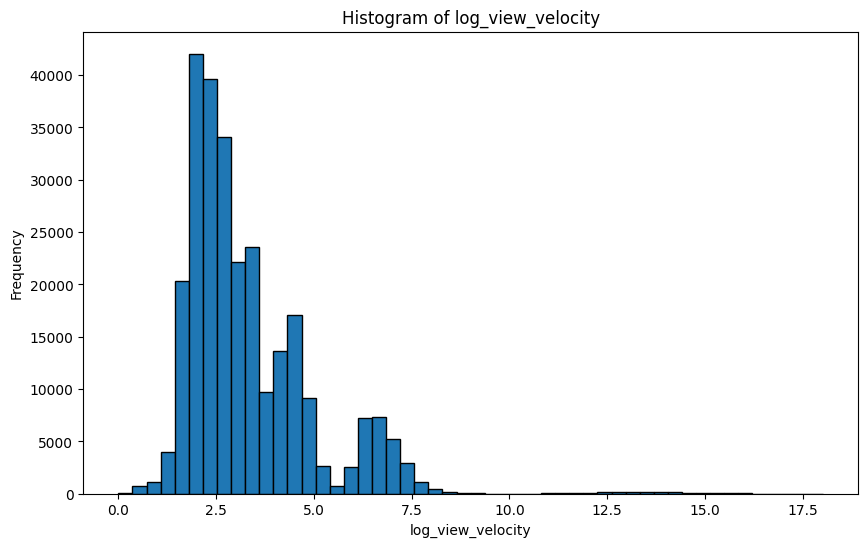

In [ ]:
# histogram for view_velocity

plt.figure(figsize=(10, 6))
plt.hist(data_df['log_view_velocity'], bins=50, edgecolor='black')
plt.xlabel('log_view_velocity')
plt.ylabel('Frequency')
plt.title('Histogram of log_view_velocity')
plt.show()

##**Train the model**

In [ ]:
# Step 1: Define feature columns based on your provided feature sets
day_of_week_columns = [col for col in data_df.columns if 'published_day_of_week' in col]
# top 15 categories
category_columns = [col for col in encoded_categories_df.columns]
# top 100 channels
channelId_columns = [col for col in encoded_channels_df.columns]

# Include the other feature columns
feature_columns = ['channelTitle_length', 'tag_count', 'days_since_published',
                   'square_days_since_published', 'sqrt_days_since_published',
                   'log_days_since_published'] + category_columns + day_of_week_columns + channelId_columns

# Label column is log_view_velocity
label_column = 'log_view_velocity'

##Dividing into train, validation, and test

In [ ]:
# Step 2: Split the data into training, validation, and test sets based on date ranges
train_df = data_df[(data_df['trending_date'] >= '2023-01-01') & (data_df['trending_date'] <= '2023-12-31')]
validation_df = data_df[(data_df['trending_date'] > '2023-12-31') & (data_df['trending_date'] <= '2024-02-18')]
test_df = data_df[data_df['trending_date'] > '2024-02-18']

# Step 3: Prepare features and labels for each set
X_train = train_df[feature_columns]
y_train = train_df[label_column]

X_val = validation_df[feature_columns]
y_val = validation_df[label_column]

X_test = test_df[feature_columns]
y_test = test_df[label_column]

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate on all sets
# Training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Model performance metrics:")
print(f"Training MSE: {train_mse:.6f}, R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}")
print(f"Validation MSE: {val_mse:.6f}, R²: {val_r2:.6f}, RMSE: {val_rmse:.6f}")
print(f"Test MSE: {test_mse:.6f}, R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}")

Model performance metrics:
Training MSE: 0.013789, R²: 0.993891, RMSE: 0.117428
Validation MSE: 0.048732, R²: 0.978702, RMSE: 0.220754
Test MSE: 0.044904, R²: 0.980331, RMSE: 0.211906


##Plot the model

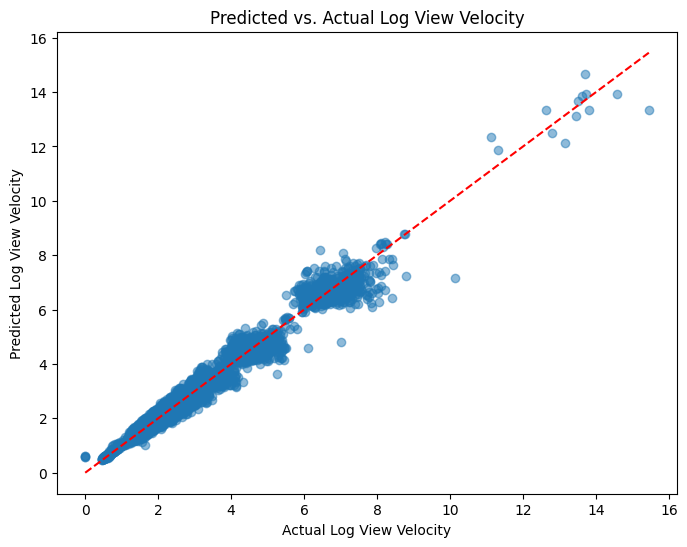

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred , alpha=0.5)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line for reference
plt.show()


##Plot of important features

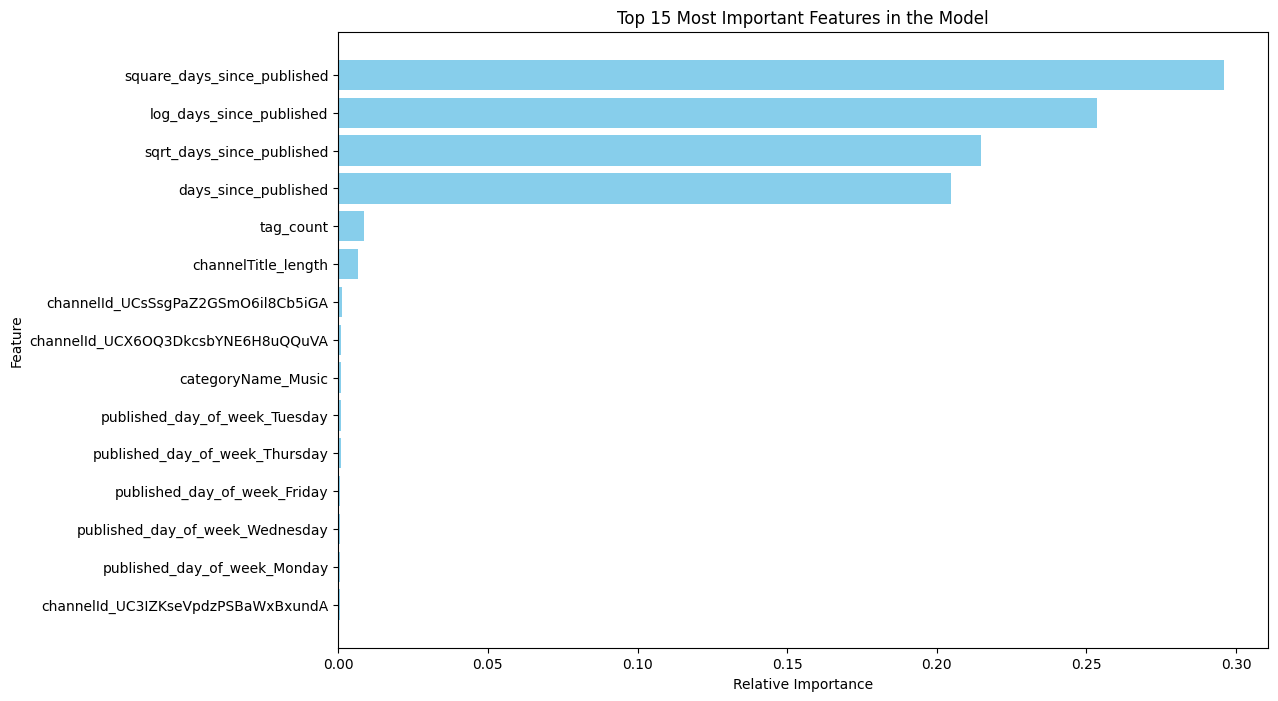

In [ ]:
# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 most important features
top_features = feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features in the Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


##Plot of predicted vs. actual views

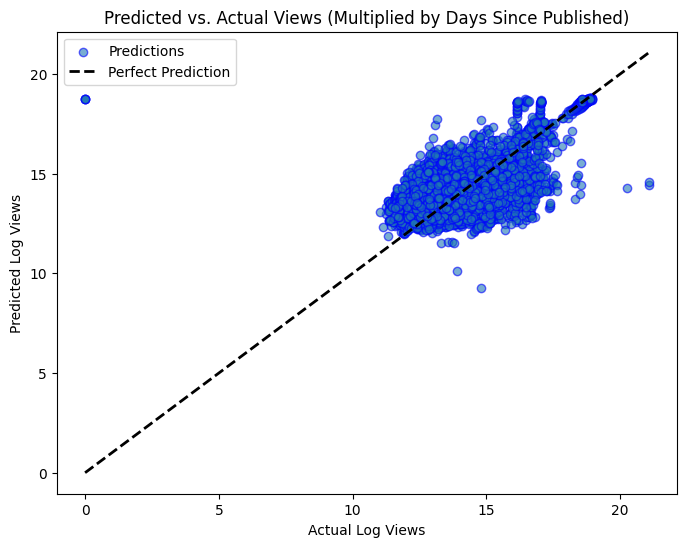

In [ ]:
# Ensure index alignment between y_test, y_pred, and days_since_published
days_since_published_test = data_df.loc[y_test.index, 'days_since_published']

# Multiply actual and predicted values by days since published
# brings the model predictions back to a scale that resembles the original log(view_count) values
actual_multiplied = y_test * days_since_published_test
predicted_multiplied = y_test_pred * days_since_published_test

# Create a scatter plot of predicted vs. actual values

plt.figure(figsize=(8, 6))
plt.scatter(actual_multiplied, predicted_multiplied, alpha=0.6, edgecolors='b', label='Predictions')
plt.xlabel("Actual Log Views")
plt.ylabel("Predicted Log Views")
plt.title("Predicted vs. Actual Views (Multiplied by Days Since Published)")

# Add a diagonal line for perfect predictions
plt.plot([actual_multiplied.min(), actual_multiplied.max()],
         [actual_multiplied.min(), actual_multiplied.max()], 'k--', lw=2, label='Perfect Prediction')

plt.legend()
plt.show()


##Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],         # Number of trees in the forest
    'max_depth': [None, 10, 20],     # Maximum depth of each tree
    'min_samples_split': [2, 5],             # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],               # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],    # Number of features to consider at each split
    'bootstrap': [True]                   # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,             # Number of parameter settings to sample
    cv=5,                  # Cross-validation splitting strategy
    scoring='neg_mean_squared_error',  # Scoring metric
    random_state=42,
    n_jobs=1              # Use a single cores
)

# Use a random sample of the training data for tuning
sample_df = train_df.sample(frac=0.3, random_state=42)  # 30% of the data
X_sample = sample_df[feature_columns]
y_sample = sample_df[label_column]

# Fit the random search model
random_search.fit(X_sample, y_sample)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on validation and test sets
y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Output the best hyperparameters and performance metrics
print("Best Hyperparameters:", best_params)
print(f"Validation MSE: {val_mse:.6f}, R²: {val_r2:.6f}, RMSE: {val_rmse:.6f}")
print(f"Test MSE: {test_mse:.6f}, R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}")


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Validation MSE: 0.051896, R²: 0.977320, RMSE: 0.227806
Test MSE: 0.047936, R²: 0.979003, RMSE: 0.218943


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Retrain the model on the full training data
best_model.fit(X_train, y_train)

# Predict on training data
y_train_pred = best_model.predict(X_train)

# Predict on validation data
y_val_pred = best_model.predict(X_val)

# Predict on test data
y_test_pred = best_model.predict(X_test)

# Calculate metrics for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Calculate metrics for validation data
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Calculate metrics for test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Print metrics
print("Training Performance:")
print(f"MSE: {train_mse:.6f}, R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}")

print("\nValidation Performance:")
print(f"MSE: {val_mse:.6f}, R²: {val_r2:.6f}, RMSE: {val_rmse:.6f}")

print("\nTest Performance:")
print(f"MSE: {test_mse:.6f}, R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}")


Training Performance:
MSE: 0.023197, R²: 0.989724, RMSE: 0.152306

Validation Performance:
MSE: 0.047579, R²: 0.979206, RMSE: 0.218126

Test Performance:
MSE: 0.044005, R²: 0.980725, RMSE: 0.209774


##Residual Analysis

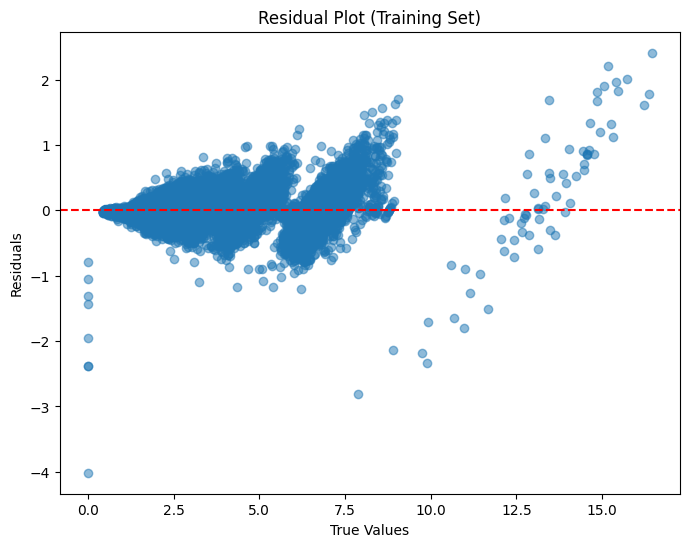

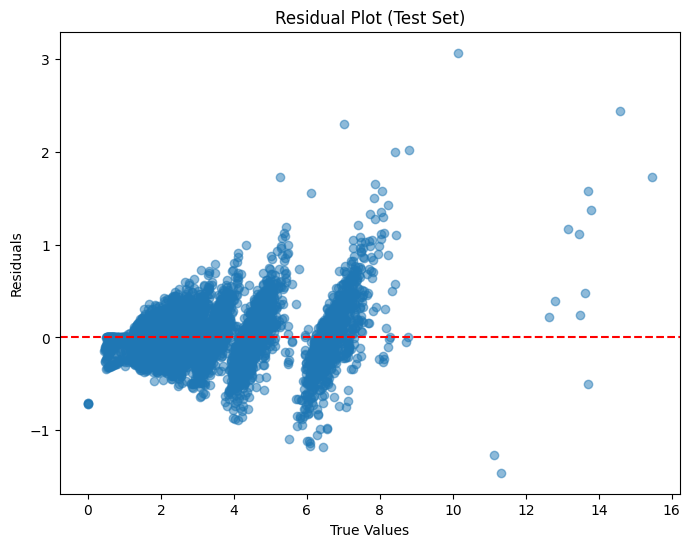

In [ ]:
import matplotlib.pyplot as plt

# Residuals for training
train_residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_train, train_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Training Set)")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

# Residuals for test
test_residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Test Set)")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()


## Learning Curve Analysis

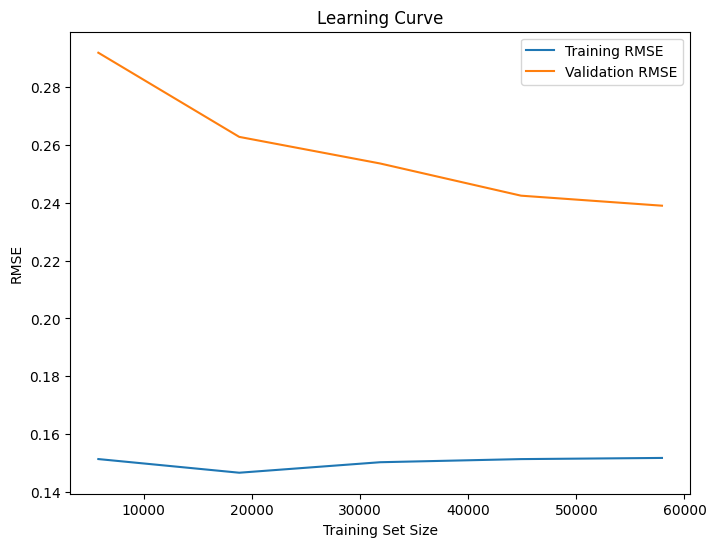

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_rmse, label="Training RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Set increased values for min_samples_leaf and min_samples_split
model = RandomForestRegressor(
    n_estimators=100,           # Number of trees
    max_depth=None,             # Unlimited depth
    min_samples_split=5,       # Increased minimum samples to split a node
    min_samples_leaf=1,         # Increased minimum samples at leaf nodes
    max_features='sqrt',        # Number of features to consider for split
    bootstrap=True,             # Use bootstrapped samples
    random_state=42             # Random state for reproducibility
)

# Train the model on the full training set
model.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Print the results
print("Model Evaluation Metrics (After Increasing Regularization):\n")
print("Training Performance:")
print(f"MSE: {train_mse:.6f}, R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}")

print("\nValidation Performance:")
print(f"MSE: {val_mse:.6f}, R²: {val_r2:.6f}, RMSE: {val_rmse:.6f}")

print("\nTest Performance:")
print(f"MSE: {test_mse:.6f}, R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}")


Model Evaluation Metrics (After Increasing Regularization):

Training Performance:
MSE: 0.023197, R²: 0.989724, RMSE: 0.152306

Validation Performance:
MSE: 0.047579, R²: 0.979206, RMSE: 0.218126

Test Performance:
MSE: 0.044005, R²: 0.980725, RMSE: 0.209774


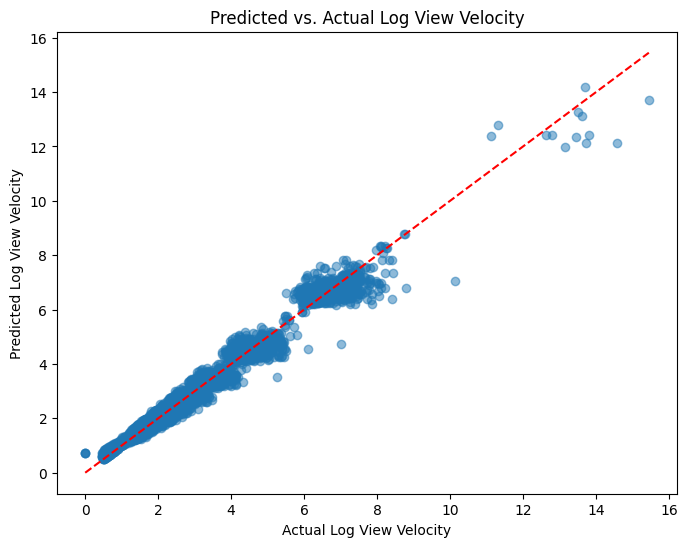

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred , alpha=0.5)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line for reference
plt.show()


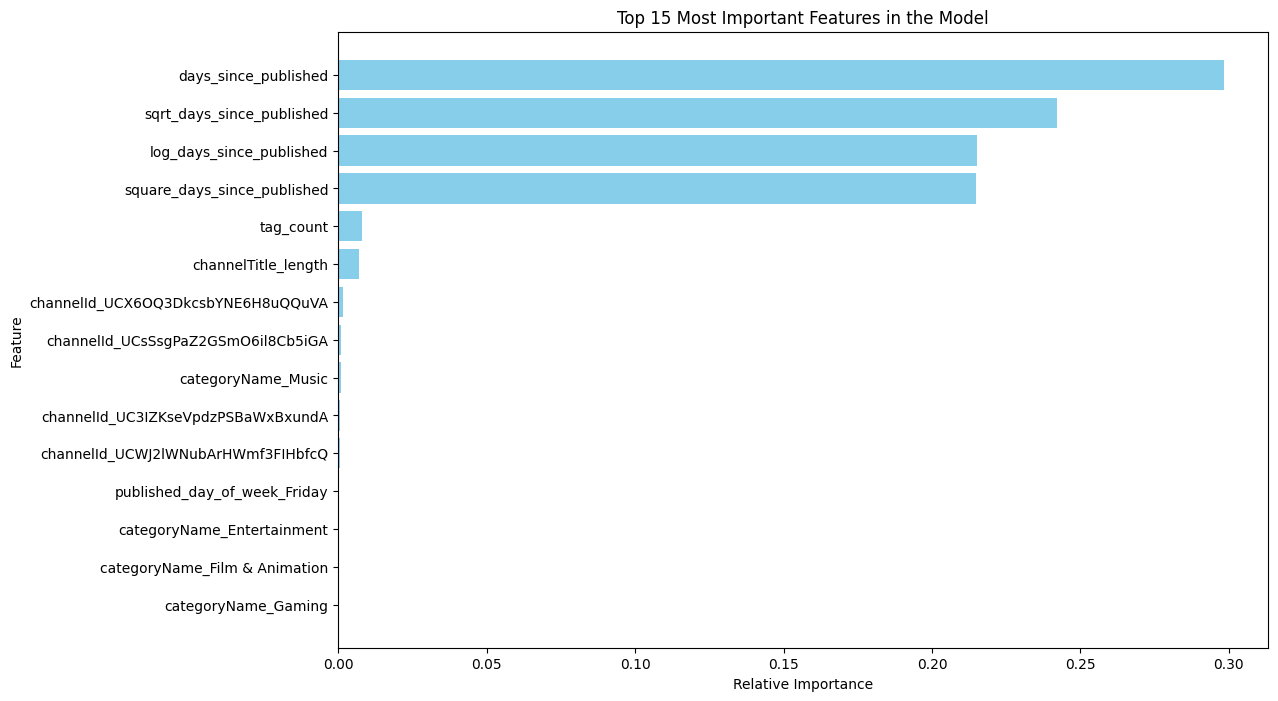

In [ ]:
# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 most important features
top_features = feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features in the Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


##**Train the model using a simple RNN**

##Tokenize the description Text

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters for tokenization and padding
vocab_size = 5000  # Limit the vocabulary size
max_length = 100   # Maximum length for padding

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data_df['description'].fillna(''))

# Convert descriptions to sequences and pad them
sequences = tokenizer.texts_to_sequences(data_df['description'].fillna(''))
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


##Build and Train a Simple RNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# RNN model parameters
embedding_dim = 64
rnn_units = 32

# Define the RNN model
rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(rnn_units),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression output
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the padded descriptions and the target variable
# Note: This assumes `label_column` is the target for the description text alone
rnn_model.fit(padded_sequences, data_df[label_column], epochs=5, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 255s 30ms/step - loss: 2.9826
Epoch 2/5
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 251s 30ms/step - loss: 2.6721
Epoch 3/5
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 268s 31ms/step - loss: 2.6915
Epoch 4/5
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 263s 31ms/step - loss: 2.6612
Epoch 5/5
8400/8400 ━━━━━━━━━━━━━━━━━━━━ 258s 31ms/step - loss: 2.6769


##Extract RNN Features

In [ ]:
# Extract RNN features for each description
rnn_features = rnn_model.predict(padded_sequences)
data_df['rnn_feature'] = rnn_features


8400/8400 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step


##Integrate RNN Features with Existing Features and Split the Data

In [ ]:
# Define feature columns, including the RNN feature
feature_columns = feature_columns + ['rnn_feature']

# Split the data into training, validation, and test sets
train_df = data_df[(data_df['trending_date'] >= '2023-01-01') & (data_df['trending_date'] <= '2023-12-31')]
validation_df = data_df[(data_df['trending_date'] > '2023-12-31') & (data_df['trending_date'] <= '2024-02-18')]
test_df = data_df[data_df['trending_date'] > '2024-02-18']

# Prepare features and labels for each set
X_train = train_df[feature_columns]
y_train = train_df[label_column]

X_val = validation_df[feature_columns]
y_val = validation_df[label_column]

X_test = test_df[feature_columns]
y_test = test_df[label_column]


##Train the Random Forest Model with Combined Features

In [ ]:
# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate on all sets
# Training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

# Validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

# Test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Model performance metrics with RNN features:")
print(f"Training MSE: {train_mse:.6f}, R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}")
print(f"Validation MSE: {val_mse:.6f}, R²: {val_r2:.6f}, RMSE: {val_rmse:.6f}")
print(f"Test MSE: {test_mse:.6f}, R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}")


Model performance metrics with RNN features:
Training MSE: 0.007331, R²: 0.996752, RMSE: 0.085620
Validation MSE: 0.044199, R²: 0.980683, RMSE: 0.210236
Test MSE: 0.042120, R²: 0.981551, RMSE: 0.205231


##Plot of the model with RNN

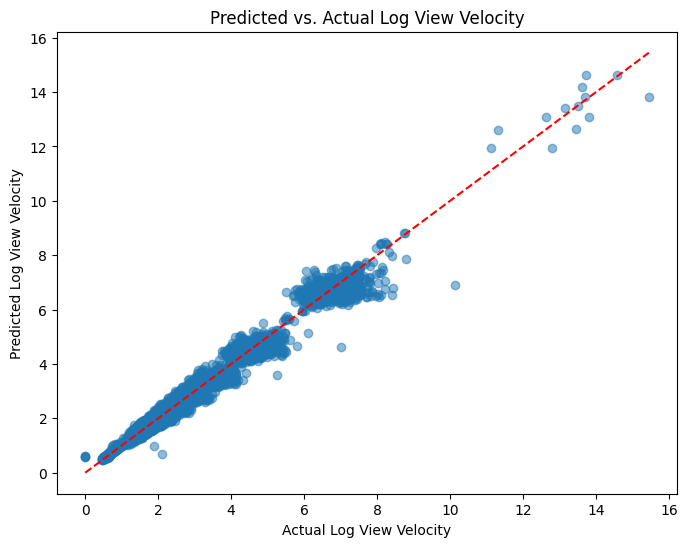

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred , alpha=0.5)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line for reference
plt.show()


##Plot of important features with RNN

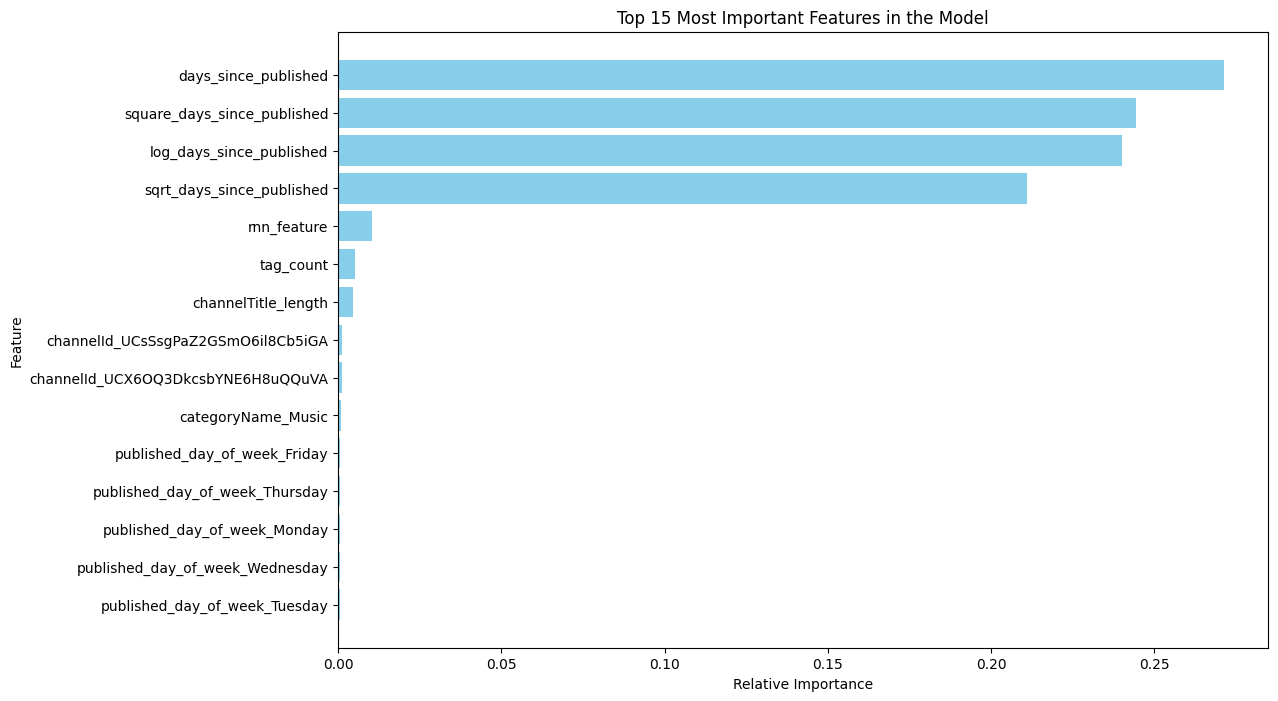

In [ ]:
# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 most important features
top_features = feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features in the Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
